# SOEN 471 Project

The objective of our project is to train a data model to classify football players into different positions (Forward, Midfielder, Defender), based on both their skill and performance characteristics, utilizing a **supervised classification** model.

Our model runs on three different algorithms: **Decision Tree**, **Random Forest** and **K-Nearest Neighbors (KNN)**.

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import pathlib
import shutil
import numpy as np
import pyspark.sql.functions as F
import findspark
import os
import sys

from data_processing import *
from datetime import datetime
from knn import cleanup_data_and_store_as_parquet, printf, predict

from IPython.display import display

from pyspark.sql.types import IntegerType
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, when, col
from pyspark.sql.functions import array, col, monotonically_increasing_id, row_number
from pyspark.sql.window import Window
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StringIndexer,VectorAssembler

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

### Spark Initialization/ Environment Setup

In [2]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

findspark.init()

def init_spark():
    spark = (
        SparkSession.builder.appName("SOEN 471 Project")
        .config("spark.some.config.option", "some-value")
        .getOrCreate()
    )
    return spark

## 1. Data Preparation

### 1.1 Sample of Initial Data

<p>Initial row count is of 10,003,590 values, and the dataset contains a total of 110 different features.</p>

In [3]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')

spark = init_spark()

df1 = spark.read.csv(os.path.join(data_dir, 'male_players1.csv'), header=True)
df2 = spark.read.csv(os.path.join(data_dir, 'male_players2.csv'), header=True)
df3 = spark.read.csv(os.path.join(data_dir, 'male_players3.csv'), header=True)
df4 = spark.read.csv(os.path.join(data_dir, 'male_players4.csv'), header=True)
df5 = spark.read.csv(os.path.join(data_dir, 'male_players5.csv'), header=True)
df6 = spark.read.csv(os.path.join(data_dir, 'male_players6.csv'), header=True)

players = df1.union(df2).union(df3).union(df4).union(df5).union(df6)

sample = players.take(5)
sample = pd.DataFrame(sample, columns=sample[0].__fields__)
sample = sample.drop(sample.columns[0], axis=1)

display(sample)

,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url
0,158023,/player/158023/lionel-messi/230009,23,9,2023-01-13,L. Messi,Lionel Andrés Messi Cuccittini,RW,91,91,...,63+3,63+3,64+3,59+3,50+3,50+3,50+3,59+3,19+3,https://cdn.sofifa.net/players/158/023/23_120.png
1,165153,/player/165153/karim-benzema/230009,23,9,2023-01-13,K. Benzema,Karim Benzema,"CF, ST",91,91,...,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3,https://cdn.sofifa.net/players/165/153/23_120.png
2,188545,/player/188545/robert-lewandowski/230009,23,9,2023-01-13,R. Lewandowski,Robert Lewandowski,ST,91,91,...,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/23_120.png
3,192985,/player/192985/kevin-de-bruyne/230009,23,9,2023-01-13,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,...,79+3,79+3,78+3,74+3,68+3,68+3,68+3,74+3,21+3,https://cdn.sofifa.net/players/192/985/23_120.png
4,231747,/player/231747/kylian-mbappe/230009,23,9,2023-01-13,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,95,...,63+3,63+3,67+3,63+3,54+3,54+3,54+3,63+3,18+3,https://cdn.sofifa.net/players/231/747/23_120.png


### 1.2 Sample of Final Data

<p>Summary of all steps performed in the data preparation phase:</p>
<li>Select all field-related features.
<li>Discard all goalkeepers / goal-keeping attributes from the dataset (too many null values).
<li>Drop features that are not discriminative towards any class (same values can easily be obtained by players of all classes).
<li>Select most preferred position for each player.
<li>Convert FIFA-defined position (RW, CF, ST) to one of three labels (Forward, Midfielder, or Defender).
<li>Drop null rows.
<li>Cast all values to integers.

<p>Total number of features: 28

Reduced our row count from 10,003,590 to 8,882,438.<p>

In [4]:
players = players.select(
        "player_positions",
        "pace",
        "shooting",
        "passing",
        "dribbling",
        "defending",
        "attacking_crossing",
        "attacking_finishing",
        "attacking_heading_accuracy",
        "attacking_short_passing",
        "attacking_volleys",
        "skill_dribbling",
        "skill_fk_accuracy",
        "skill_long_passing",
        "skill_ball_control",
        "movement_acceleration",
        "movement_sprint_speed",
        "movement_agility",
        "movement_balance",
        "power_shot_power",
        "power_stamina",
        "power_long_shots",
        "mentality_interceptions",
        "mentality_positioning",
        "mentality_penalties",
        "defending_marking_awareness",
        "defending_standing_tackle",
        "defending_sliding_tackle",
    )

players = players.withColumn(
        "player_position", split(players["player_positions"], ",")[0]
    ).drop("player_positions")

players = players.filter(players.player_position != "GK")

players = players.withColumn(
        "label_position", label_conversion(players["player_position"])
    ).drop("player_position").dropna()

for col_name in players.columns:
        if col_name != "label_position":
            players = players.withColumn(col_name, col(col_name).cast(IntegerType()))

sample = players.take(10)
sample = pd.DataFrame(sample, columns=sample[0].__fields__)
display(sample)

,pace,shooting,passing,dribbling,defending,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,...,power_shot_power,power_stamina,power_long_shots,mentality_interceptions,mentality_positioning,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,label_position
0,81,89,90,94,34,84,90,70,91,88,...,86,70,91,40,93,75,20,35,24,Forward
1,80,88,83,87,39,75,92,90,89,88,...,87,82,80,39,92,84,43,24,18,Forward
2,75,91,79,86,44,71,94,91,84,89,...,91,76,84,49,94,90,35,42,19,Forward
3,74,88,93,87,63,94,85,55,93,83,...,92,89,91,64,88,83,65,65,53,Midfielder
4,97,89,80,92,36,78,93,72,85,83,...,88,87,82,38,92,80,26,34,32,Forward
5,90,89,82,90,45,80,93,59,84,84,...,83,87,85,55,92,86,38,43,41,Forward
6,87,83,85,93,37,83,83,63,85,86,...,79,79,81,37,86,91,35,32,29,Forward
7,63,73,78,73,88,62,64,81,84,65,...,88,88,81,88,75,66,90,88,87,Midfielder
8,69,91,83,83,47,80,93,85,84,87,...,92,83,86,44,94,92,50,36,38,Forward
9,81,60,71,72,90,53,52,86,79,45,...,81,74,64,89,47,62,91,91,86,Defender


Dataset counts **3,266,866** Defenders, **3,712,577** Midfielders, and **1,902,995** Forwards.

### 1.3 Data Sampling

<p>As an attempt to improve results, we undersample the data to reduce class imbalance, returning <b>1,500,000</b> player values for each of the three classes (also easily splittable into two thirds training and one third testing).</p>

In [5]:
defenders = players.filter(players.label_position == "Defender")
midfielders = players.filter(players.label_position == "Midfielder")
forwards = players.filter(players.label_position == "Forward")

In [6]:
defenders = defenders.sample(fraction=1500000 / defenders.count()).limit(1500000)
midfielders = midfielders.sample(fraction=1500000 / midfielders.count()).limit(1500000)
forwards = forwards.sample(fraction=1500000 / forwards.count()).limit(1500000)

sampled_players = defenders.union(midfielders).union(forwards)

print("Defenders: {}".format(defenders.count()))
print("Midfielders: {}".format(midfielders.count()))
print("Forwards: {}".format(forwards.count()))
print("Total number of sampled players: {}".format(sampled_players.count()))

Defenders: 1499208
Midfielders: 1498360
Forwards: 1500000
Total number of sampled players: 4497568


## 2. Evaluation of Supervised Classification Algorithms

<p>The male_players.csv dataset is used to train a Decision Tree model, a Random Forest Model, and a K-nearest neighbors (KNN) model . The dataset is first preprocessed by encoding the categorical label data to a numerical values column. Next, these models are trained on a training set that consists of 2/3 of the dataset, and evaluated by the remaining 1/3 of the dataset, the test set, to evaluate the performance of the trained model. Lastly, a classification report and confusion matrix is generated to assess the accuracy and quality of the trained models.</p>

In [7]:
def evaluation(testSetLabels, predictions, features):
    # Compute evaluation metrics
    cr = classification_report(testSetLabels,predictions, target_names= features, output_dict=True)
    report_df = pd.DataFrame.from_dict(cr).transpose()
    print("Classification Report:")
    print(report_df)
    cm = confusion_matrix(testSetLabels, predictions)
    print("\nConfusion Matrix")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = features)
    disp.plot()
    pl.show()
    

## 2.1 Evaluation Of Entire Dataset

<p><b>Note: </b>In order to be able to process the entire dataset, we have decided to use Apache Parquet, which can generate lower storage costs for data and maximize the effectiveness of data queries. This allows a large amount of data to fit in memory, reducing the time for swapping data from disks. We therefore save the training set and test set as a .parquet:

In [8]:
players = data_preparation(
    "../data/male_players1.csv",
    "../data/male_players2.csv",
    "../data/male_players3.csv",
    "../data/male_players4.csv",
    "../data/male_players5.csv",
    "../data/male_players6.csv",
)
cleanup_data_and_store_as_parquet(players)
printf("------- Using the entire dataset -------")
printf("Loading dataset...")

trainingSet = pd.read_parquet('../data/male_players_cleaned_training')
testSet = pd.read_parquet('../data/male_players_cleaned_test')
printf(
    f"Finished loading dataset. Training set: {trainingSet.shape[0]} rows, Test set: {testSet.shape[0]} rows."
)

trainingSetLabels = trainingSet.iloc[:, -1:].values.ravel()
# Drop the column "label_positions" of the training set
trainingSet = trainingSet.iloc[:, :-1]

testSetLabels = testSet.iloc[:, -1:].values.ravel()
# Drop the column "label_positions" of the test set
testSet = testSet.iloc[:, :-1]


[17:44:43.486635] ------- Using the entire dataset -------
[17:44:43.486635] Loading dataset...
[17:44:44.449880] Finished loading dataset. Training set: 5951580 rows, Test set: 2930858 rows.


### 2.1.1 Decision Tree Evaluation With No Sampling

[17:44:44.912023] Fitting Decision Tree model...
[17:45:41.357423] Finished fitting model.
[17:45:41.358426] Predicting test labels...
[17:45:41.679973] Finished predictions.
[17:45:41.680978] Evaluating predictions...

Classification Report:
              precision    recall  f1-score       support
Defender       0.898003  0.892969  0.895479  1.078477e+06
Forward        0.877276  0.751849  0.809734  6.276540e+05
Midfielder     0.797599  0.859978  0.827615  1.224727e+06
accuracy       0.848961  0.848961  0.848961  8.489613e-01
macro avg      0.857626  0.834932  0.844276  2.930858e+06
weighted avg   0.851608  0.848961  0.848758  2.930858e+06

Confusion Matrix


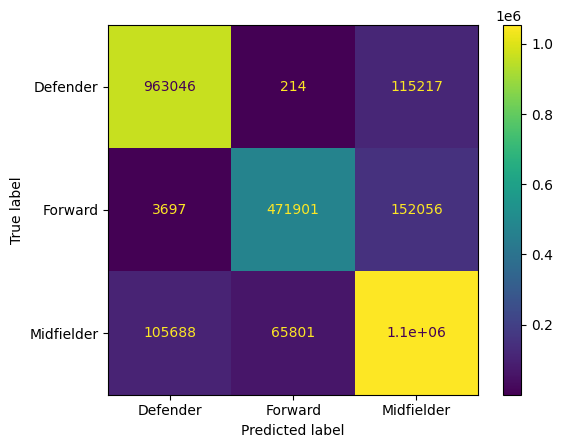

In [9]:
dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=7)
dt_predictions = predict(dt_model, "Decision Tree", trainingSet, testSet, trainingSetLabels)

printf("Evaluating predictions...\n")
evaluation(testSetLabels,dt_predictions, dt_model.classes_)

### 2.1.2 Random Forest Evaluation With No Sampling

[17:47:00.713943] Fitting Random Forest model...
[18:01:05.310047] Finished fitting model.
[18:01:05.310047] Predicting test labels...
[18:01:24.184363] Finished predictions.
[18:01:24.185372] Evaluating predictions...

Classification Report:
              precision    recall  f1-score       support
Defender       0.907068  0.927982  0.917406  1.078477e+06
Forward        0.884177  0.787144  0.832843  6.276540e+05
Midfielder     0.835043  0.865053  0.849783  1.224727e+06
accuracy       0.871525  0.871525  0.871525  8.715247e-01
macro avg      0.875429  0.860060  0.866677  2.930858e+06
weighted avg   0.872068  0.871525  0.871039  2.930858e+06

Confusion Matrix


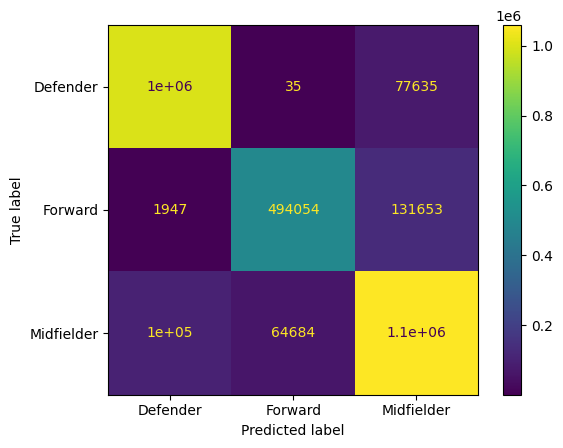

In [10]:
rf_model = RandomForestClassifier(max_depth=7, random_state=0)
rf_predictions = predict(rf_model, "Random Forest", trainingSet, testSet, trainingSetLabels)

printf("Evaluating predictions...\n")
evaluation(testSetLabels,rf_predictions, rf_model.classes_)

### 2.1.3 K-Nearest Neighbors Evaluation With No Sampling

[18:02:42.921072] Fitting KNN model...
[18:03:38.098043] Finished fitting model.
[18:03:38.098043] Predicting test labels...
[18:06:52.750625] Finished predictions.
[18:06:52.751626] Evaluating predictions...

Classification Report:
              precision    recall  f1-score       support
Defender       0.997006  0.998055  0.997530  1.078477e+06
Forward        0.990995  0.988514  0.989753  6.276540e+05
Midfielder     0.992587  0.992941  0.992764  1.224727e+06
accuracy       0.993875  0.993875  0.993875  9.938748e-01
macro avg      0.993529  0.993170  0.993349  2.930858e+06
weighted avg   0.993872  0.993875  0.993873  2.930858e+06

Confusion Matrix


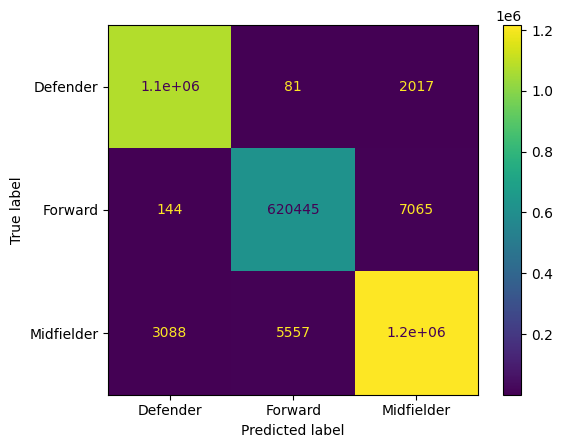

In [11]:
knn_model = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree', n_jobs=-1)
knn_predictions = predict(knn_model, "KNN", trainingSet, testSet, trainingSetLabels)

printf("Evaluating predictions...\n")
evaluation(testSetLabels,knn_predictions, knn_model.classes_)

## 2.2 Evaluation Of Undersampled Dataset

We again begin by storing the sampled dataset as a .parquet.

In [12]:
sampled_players = sampled_data()
cleanup_data_and_store_as_parquet(sampled_players)
printf("------- Using the undersampled dataset -------")
printf("Loading dataset...")

trainingSet = pd.read_parquet('../data/male_players_cleaned_training')
testSet = pd.read_parquet('../data/male_players_cleaned_test')
printf(
    f"Finished loading dataset. Training set: {trainingSet.shape[0]} rows, Test set: {testSet.shape[0]} rows."
)

trainingSetLabels = trainingSet.iloc[:, -1:].values.ravel()
# Drop the column "label_positions" of the training set
trainingSet = trainingSet.iloc[:, :-1]

testSetLabels = testSet.iloc[:, -1:].values.ravel()
# Drop the column "label_positions" of the test set
testSet = testSet.iloc[:, :-1]


[18:11:17.326049] ------- Using the undersampled dataset -------
[18:11:17.327045] Loading dataset...
[18:11:17.890172] Finished loading dataset. Training set: 3016384 rows, Test set: 1482658 rows.


### 2.2.1 Decision Tree Evaluation With Undersampling

[18:11:18.101215] Fitting Decision Tree model...
[18:11:40.824222] Finished fitting model.
[18:11:40.825223] Predicting test labels...
[18:11:40.966289] Finished predictions.
[18:11:40.973285] Evaluating predictions...

Classification Report:
              precision    recall  f1-score       support
Defender       0.899441  0.892172  0.895792  4.944540e+05
Forward        0.873003  0.859966  0.866435  4.940020e+05
Midfielder     0.762674  0.780225  0.771350  4.942020e+05
accuracy       0.844127  0.844127  0.844127  8.441272e-01
macro avg      0.845039  0.844121  0.844526  1.482658e+06
weighted avg   0.845045  0.844127  0.844531  1.482658e+06

Confusion Matrix


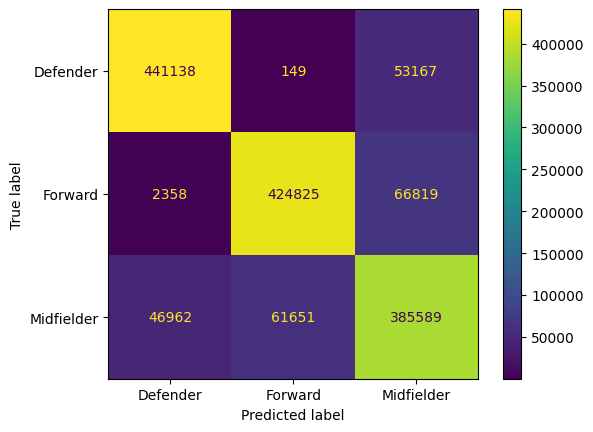

In [13]:
dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=7)
dt_predictions = predict(dt_model, "Decision Tree", trainingSet, testSet, trainingSetLabels)

printf("Evaluating predictions...\n")
evaluation(testSetLabels,dt_predictions, dt_model.classes_)

### 2.2.2 Random Forest Evaluation With Undersampling

[18:12:18.259170] Fitting Random Forest model...
[18:17:23.659846] Finished fitting model.
[18:17:23.660847] Predicting test labels...
[18:17:31.470940] Finished predictions.
[18:17:31.476939] Evaluating predictions...

Classification Report:
              precision    recall  f1-score       support
Defender       0.902455  0.939626  0.920666  4.944540e+05
Forward        0.882068  0.880063  0.881065  4.940020e+05
Midfielder     0.815769  0.784005  0.799572  4.942020e+05
accuracy       0.867909  0.867909  0.867909  8.679089e-01
macro avg      0.866764  0.867898  0.867101  1.482658e+06
weighted avg   0.866768  0.867909  0.867108  1.482658e+06

Confusion Matrix


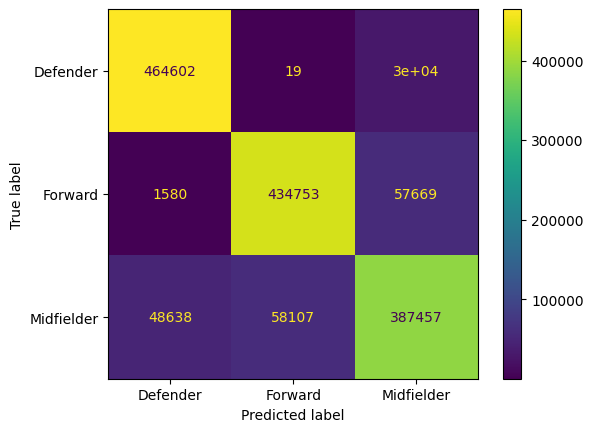

In [14]:
rf_model = RandomForestClassifier(max_depth=7, random_state=0)
rf_predictions = predict(rf_model, "Random Forest", trainingSet, testSet, trainingSetLabels)

printf("Evaluating predictions...\n")
evaluation(testSetLabels,rf_predictions, rf_model.classes_)

### 2.3.2 K-Nearest Neighbors Evaluation With Undersampling

[18:18:09.278117] Fitting KNN model...
[18:18:31.356170] Finished fitting model.
[18:18:31.356170] Predicting test labels...
[18:20:04.126757] Finished predictions.
[18:20:04.132757] Evaluating predictions...

Classification Report:
              precision    recall  f1-score       support
Defender       0.995280  0.998663  0.996968  4.944540e+05
Forward        0.995617  0.983966  0.989757  4.940020e+05
Midfielder     0.983159  0.991315  0.987220  4.942020e+05
accuracy       0.991317  0.991317  0.991317  9.913169e-01
macro avg      0.991352  0.991315  0.991315  1.482658e+06
weighted avg   0.991352  0.991317  0.991316  1.482658e+06

Confusion Matrix


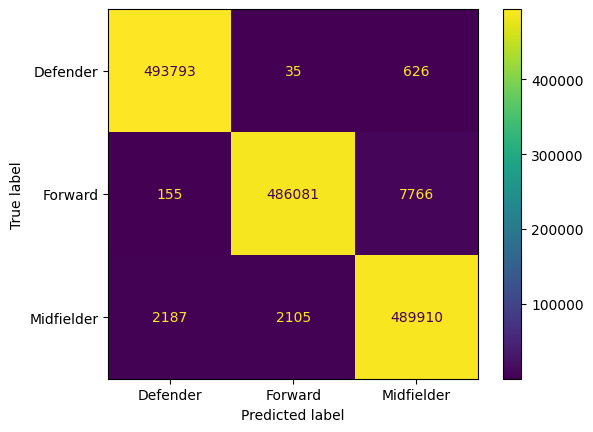

In [15]:
knn_model = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree', n_jobs=-1)
knn_predictions = predict(knn_model, "KNN", trainingSet, testSet, trainingSetLabels)

printf("Evaluating predictions...\n")
evaluation(testSetLabels,knn_predictions, knn_model.classes_)